In [6]:
import os
import rasterio
import shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_tiffs(input_folder, output_folder, new_crs='EPSG:4326'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            
            input_filepath = os.path.join(input_folder, filename)
            output_filepath = os.path.join(output_folder, filename)
            
            with rasterio.open(input_filepath) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, new_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': new_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                
                with rasterio.open(output_filepath, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=new_crs,
                            resampling=Resampling.nearest)
                        dst.tags(i).update(src.tags(i))
            
            # Copiar archivos .aux.xml si existen
            aux_xml_filepath = input_filepath + '.aux.xml'
            if os.path.exists(aux_xml_filepath):
                shutil.copy(aux_xml_filepath, output_filepath + '.aux.xml')
                
            print(f'Reprojected {filename} to {new_crs} and saved to {output_filepath}')


In [7]:
input_folder = 'data/output/labels/tiff/EPSG_3857/'
output_folder = 'data/output/labels/tiff/'
new_crs = 'EPSG:4326'  # o cualquier otro CRS que necesites

reproject_tiffs(input_folder, output_folder, new_crs)

Reprojected Bosques Arauco_Bosque 1_2022-10-10.tif to EPSG:4326 and saved to data/output/labels/tiff/Bosques Arauco_Bosque 1_2022-10-10.tif
Reprojected Bosques Bio Bio_Bosque 2_2022-04-08.tif to EPSG:4326 and saved to data/output/labels/tiff/Bosques Bio Bio_Bosque 2_2022-04-08.tif
Reprojected Incendios_Santa Juana Oeste 3A_2023-03-14.tif to EPSG:4326 and saved to data/output/labels/tiff/Incendios_Santa Juana Oeste 3A_2023-03-14.tif
Reprojected Incendios_Chiguayante 1_2022-01-11.tif to EPSG:4326 and saved to data/output/labels/tiff/Incendios_Chiguayante 1_2022-01-11.tif
Reprojected Incendios_Santa Juana Oeste 3A_2023-02-02.tif to EPSG:4326 and saved to data/output/labels/tiff/Incendios_Santa Juana Oeste 3A_2023-02-02.tif
Reprojected Incendios_Chiguayante 1_2023-03-29.tif to EPSG:4326 and saved to data/output/labels/tiff/Incendios_Chiguayante 1_2023-03-29.tif
Reprojected Bosques Bio Bio_Bosque 2_2022-03-09.tif to EPSG:4326 and saved to data/output/labels/tiff/Bosques Bio Bio_Bosque 2_202

In [1]:

            
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import os

def process_shapefiles(directory_path, remove_from_tif_path = None):
    output_data = []

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".shp"):
                filepath = os.path.join(root, file)
                gdf = gpd.read_file(filepath)
                
                # Tomar la metadata del primer polígono
                first_row = gdf.iloc[0]
                tif_file = first_row['tif']
                prev_tif_file = first_row['prev_tif']
                
                if remove_from_tif_path is not None:
                    tif_file = tif_file.replace(remove_from_tif_path, '')
                    prev_tif_file = prev_tif_file.replace(remove_from_tif_path, '')

                raster_shape, transform, crs = get_raster_info(tif_file)
                # Crear una máscara binaria de todos los polígonos en el shapefile
                geometries = gdf.geometry.values

                mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=raster_shape)

                # Guardar la metadata
                metadata = {
                    'zone': first_row['zone'],
                    'region': first_row['region'],
                    'type_index': first_row['type_index'],
                    'label': first_row['label'],
                    'tif': tif_file,
                    'prev_tif': prev_tif_file,
                    'height': raster_shape[0],
                    'width': raster_shape[1],
                    'mask': mask,
                }

                output_data.append(metadata)

    return output_data

# Función para obtener la información necesaria del archivo TIFF
def get_raster_info(tiff_filepath):
    with rasterio.open(tiff_filepath) as src:
        raster_shape = src.shape
        transform = src.transform
        crs = src.crs

    return raster_shape, transform, crs

import pprint

output = process_shapefiles('data/output/labels', 'EPSG_3857')

In [2]:
import numpy as np
from collections import defaultdict

def analyze_masks_and_labels(output):
    label_true_count = defaultdict(int)  # Contador para valores True por etiqueta
    label_false_count = defaultdict(int)  # Contador para valores False por etiqueta
    label_occurrences = defaultdict(int)  # Contador de ocurrencias por etiqueta
    
    for entry in output:
        mask = entry.get('mask')
        label = entry.get('label')
        
        if mask is not None and label is not None:
            label_true_count[label] += np.sum(mask)
            label_false_count[label] += np.size(mask) - np.sum(mask)
            label_occurrences[label] += 1  # Cuenta cada ocurrencia de la etiqueta
            
    # Imprime los resultados
    print("Label occurrences:")
    for label, count in label_occurrences.items():
        print(f"{label}: {count} times")
        
    print("\nTrue values in masks by label:")
    for label, count in label_true_count.items():
        print(f"{label}: {count} True values")
        
    print("\nFalse values in masks by label:")
    for label, count in label_false_count.items():
        print(f"{label}: {count} False values")

# Asumiendo que 'output' es tu lista de diccionarios
analyze_masks_and_labels(output)



Label occurrences:
Talado: 21 times
Quemado: 12 times
Bosque: 7 times

True values in masks by label:
Talado: 106764 True values
Quemado: 316263 True values
Bosque: 552283 True values

False values in masks by label:
Talado: 2144492 False values
Quemado: 3259861 False values
Bosque: 892500 False values


In [3]:
import numpy as np
import rasterio

def extract_masked_pixels_and_bands(tiff_path, mask):
    """
    Esta función extrae los píxeles de un archivo TIFF que están dentro de las áreas de una máscara,
    y devuelve una lista de los valores de píxeles de múltiples bandas y los nombres de las bandas.
    """
    with rasterio.open(tiff_path) as src:
        # Obtener los nombres de las bandas
        band_names = src.descriptions
        band_names = [f'band_{i+1}' if name is None else name for i, name in enumerate(band_names)]
        # Leer y aplicar la máscara a todas las bandas
        masked_pixels = []
        for bidx in range(1, src.count+1):
            band_data = src.read(bidx)
            masked_pixels.append(band_data[mask])
        
        # Transponer la lista para que cada píxel sea una lista de valores de todas las bandas
        masked_pixels = np.array(masked_pixels).T.tolist()
        
    return masked_pixels, band_names

In [4]:
def add_pixels_and_bands_to_metadata(output_data):
    for entry in output_data:
        tif_file = entry['tif']
        prev_tif_file = entry['prev_tif']
        mask = entry['mask']
        
        # Extracting pixel values and band names
        pixels, band_names = extract_masked_pixels_and_bands(tif_file, mask)
        
        # Adding pixel values and band names to metadata
        entry['pixels'] = pixels
        entry['band_names'] = band_names
        entry['prev_pixels'] = extract_masked_pixels_and_bands(prev_tif_file, mask)[0]

    return output_data

In [5]:
output_enriched = add_pixels_and_bands_to_metadata(output)

In [6]:
import numpy as np

def normalize_global_pixels(output_data):
    """
    Normalize pixel values globally across all entries in output_data.
    
    Parameters:
    - output_data : list of dicts
        Each entry contains 'pixels' which is a list of lists of pixel values to be normalized.
    
    Returns:
    - output_data : list of dicts
        The input list of dictionaries, but with an added key 'pixels_normalized' in each
        dictionary containing the normalized pixel values.
    """
    
    # Step 1: Find global minimum and maximum pixel values for each band
    all_pixels = [pixel for entry in output_data for pixel in entry['pixels']]
    all_pixels = np.array(all_pixels)
    
    min_global = np.min(all_pixels, axis=(0, 1))
    max_global = np.max(all_pixels, axis=(0, 1))
    
    # Step 2: Normalize all pixel values using global min and max for each band
    # Step 3: Add normalized pixel values back to metadata
    for entry in output_data:
        pixels = np.array(entry['pixels'])
        pixels_normalized = (pixels - min_global) / (max_global - min_global)
        entry['pixels_normalized'] = pixels_normalized.tolist()
        
    return output_data



In [7]:
output_enriched_normalized = normalize_global_pixels(output_enriched)

In [8]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(output_data):
    # Inicializar el LabelEncoder
    le = LabelEncoder()
    
    # Extraer todas las etiquetas y ajustar el LabelEncoder
    labels = [entry['label'] for entry in output_data]
    le.fit(labels)
    
    # Transformar las etiquetas y agregarlas a la metadata
    for entry in output_data:
        entry['encoded_label'] = le.transform([entry['label']])[0]

    return output_data, le.classes_

# Ahora, la función encode_labels agregará una nueva clave 'encoded_label' a cada entrada en output_data.
output_enriched, label_classes = encode_labels(output_enriched)

In [9]:
print (label_classes)
print(output_enriched_normalized[5]['encoded_label'])

['Bosque' 'Quemado' 'Talado']
1


In [10]:
print(output_enriched_normalized[1]['pixels_normalized'][0])

[0.02734001910219675, 0.041189111747851004, 0.05933619866284623, 0.11664278892072588, 0.1399235912129895, 0.15293696275071633, 0.07414040114613181, 0.09169054441260745, 0.11628462273161413, 0.0005969436485195798, 0.14625119388729704, 0.10828557784145176]


In [11]:
band_names = ['blue', 'green', 'red', 'nir', 'nir08', 'nir09', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22']
selected_bands = ['blue', 'green', 'red', 'nir', 'nir08', 'nir09', 'rededge1', 'rededge2', 'rededge3', 'swir16', 'swir22']


In [12]:
from sklearn.model_selection import train_test_split

# Asumiendo que pixels_and_labels es una lista de diccionarios donde cada diccionario tiene
# una clave 'pixels' y una clave 'label'

pixels = []
labels = []

for entry in output_enriched_normalized:
    for pixel_values in entry['pixels_normalized']:
        filtered_pixel = [pixel_values[band_names.index(band)] for band in selected_bands]
        pixels.append(filtered_pixel)
        labels.append(entry['encoded_label'])

print("Number of pixels:", len(pixels))
print(f'First pixel values: {pixels[0]}')

# Convertir a arrays
X = np.array(pixels)
y = np.array(labels)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number of samples:", len(y))

Number of pixels: 975310
First pixel values: [0.0508595988538682, 0.0733046800382044, 0.07175262655205349, 0.29847182425978985, 0.31530563514804205, 0.2903533906399236, 0.13658070678127984, 0.24379178605539636, 0.28581661891117477, 0.24295606494746896, 0.14804202483285578]
Number of samples: 975310


In [ ]:
# Entrenar Random Forest
rf_model = RandomForestClassifier( 
    n_estimators=500, 
    min_samples_split=10, 
    min_samples_leaf=1, 
    max_depth=30, 
    bootstrap=False,
    n_jobs=-1  # Esto permitirá que el clasificador use todos los procesadores disponibles
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=10,
                       n_estimators=500, n_jobs=-1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(rf_model, threshold=-np.inf, prefit=True)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_classes))
print("Accuracy:", accuracy_score(y_test, y_pred))
feature_importance = rf_model.feature_importances_
feature_importance = [(selected_bands[i], importance) for i, importance in enumerate(feature_importance)]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Características más importantes:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

In [ ]:
# Entrenar Random Forest
rf_model = RandomForestClassifier( 
    n_jobs=-1  # Esto permitirá que el clasificador use todos los procesadores disponibles
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(rf_model, threshold=-np.inf, prefit=True)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_classes))
print("Accuracy:", accuracy_score(y_test, y_pred))
feature_importance = rf_model.feature_importances_
feature_importance = [(selected_bands[i], importance) for i, importance in enumerate(feature_importance)]
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Características más importantes:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

              precision    recall  f1-score   support

      Bosque       1.00      1.00      1.00    110302
     Quemado       1.00      1.00      1.00     63311
      Talado       0.99      0.98      0.99     21449

    accuracy                           1.00    195062
   macro avg       1.00      0.99      0.99    195062
weighted avg       1.00      1.00      1.00    195062

Accuracy: 0.9969291814910131
Características más importantes:
red: 0.28969100964169014
nir09: 0.18121318422150784
rededge3: 0.08684480667532775
swir22: 0.07766349831951425
nir08: 0.07433880873074439
swir16: 0.06479004593991441
rededge2: 0.0607084895051184
rededge1: 0.05382040571863618
blue: 0.049542765706678024
nir: 0.048482835959128834
green: 0.012904149581739579


In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Instanciar y entrenar el modelo SVM
svm_model = SVC(C=500, gamma=50)
svm_model.fit(X_train, y_train)

# Predecir y evaluar el modelo SVM
y_pred_svm = svm_model.predict(X_test)
print("Evaluación del modelo SVM:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Evaluación del modelo SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110302
           1       0.99      0.99      0.99     63311
           2       0.98      0.97      0.97     21449

    accuracy                           0.99    195062
   macro avg       0.99      0.99      0.99    195062
weighted avg       0.99      0.99      0.99    195062

Accuracy: 0.9936738062769787


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir los hiperparámetros para la búsqueda
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 500],
    'gamma': ['scale', 'auto', 0.1, 1, 10, 50],
    #'kernel': ['rbf', 'linear', 'poly']
}

svm = SVC()

# Utilizar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs= -1, verbose=10)
grid_search_svm.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(grid_search_svm.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[CV 1/3; 1/30] START C=0.1, gamma=scale.........................................
[CV 2/3; 1/30] START C=0.1, gamma=scale.........................................
[CV 1/3; 4/30] START C=0.1, gamma=1.............................................
[CV 3/3; 2/30] START C=0.1, gamma=auto..........................................
[CV 1/3; 2/30] START C=0.1, gamma=auto..........................................
[CV 3/3; 5/30] START C=0.1, gamma=10............................................
[CV 3/3; 3/30] START C=0.1, gamma=0.1...........................................
[CV 1/3; 5/30] START C=0.1, gamma=10............................................
[CV 2/3; 3/30] START C=0.1, gamma=0.1...........................................
[CV 2/3; 6/30] START C=0.1, gamma=50............................................
[CV 3/3; 1/30] START C=0.1, gamma=scale.........................................
[CV 2/3; 4/30] START C=0.1, gamma=1.............................................
[CV 2/3; 2/30] START C=0.1, 

/home/jvl/tesina/.tesina/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 12/30] START C=1, gamma=50.............................................
[CV 3/3; 8/30] END ............C=1, gamma=auto;, score=0.979 total time=109.7min
[CV 1/3; 13/30] START C=10, gamma=scale.........................................
[CV 3/3; 9/30] END .............C=1, gamma=0.1;, score=0.980 total time=106.7min
[CV 2/3; 13/30] START C=10, gamma=scale.........................................
[CV 1/3; 4/30] END .............C=0.1, gamma=1;, score=0.979 total time=149.5min
[CV 3/3; 13/30] START C=10, gamma=scale.........................................
[CV 3/3; 11/30] END ..............C=1, gamma=10;, score=0.989 total time=18.7min
[CV 1/3; 14/30] START C=10, gamma=auto..........................................
[CV 3/3; 6/30] END ............C=0.1, gamma=50;, score=0.989 total time=155.2min
[CV 2/3; 14/30] START C=10, gamma=auto..........................................
[CV 2/3; 12/30] END ..............C=1, gamma=50;, score=0.991 total time=17.3min
[CV 3/3; 14/30] START C=10, 

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir los hiperparámetros para la búsqueda
param_grid_svm = {
    'C': [ 100, 500, 1000],
    'gamma': [ 10, 50, 100],
    #'kernel': ['rbf', 'linear', 'poly']
}

svm = SVC()

# Utilizar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs= 6, verbose=10)
grid_search_svm.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(grid_search_svm.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 2/9] START C=100, gamma=50.............................................[CV 3/3; 1/9] START C=100, gamma=10.............................................[CV 2/3; 2/9] START C=100, gamma=50.............................................[CV 2/3; 1/9] START C=100, gamma=10.............................................


[CV 1/3; 1/9] START C=100, gamma=10.............................................
[CV 3/3; 2/9] START C=100, gamma=50.............................................

[CV 3/3; 1/9] END ..............C=100, gamma=10;, score=0.991 total time=11.9min
[CV 1/3; 3/9] START C=100, gamma=100............................................
[CV 2/3; 1/9] END ..............C=100, gamma=10;, score=0.991 total time=12.0min
[CV 2/3; 3/9] START C=100, gamma=100............................................
[CV 1/3; 1/9] END ..............C=100, gamma=10;, score=0.991 total time=12.1min
[CV 3/3; 3/9] START C=100, gamma=100.............

KeyboardInterrupt: 

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los hiperparámetros para la búsqueda
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

# Utilizar GridSearchCV para encontrar los mejores hiperparámetros
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=3, verbose=10)
grid_search_knn.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(grid_search_knn.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 2/3; 1/30] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 3/3; 2/30] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 3/3; 1/30] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 2/3; 2/30] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 1/3; 2/30] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 3/3; 2/30] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.994 total time=  30.3s
[CV 1/3; 3/30] START metric=euclidean, n_neighbors=5, weights=uniform...........
[CV 2/3; 2/30] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.994 total time=  30.7s
[CV 2/3; 3/30] START metric=euclidean, n_neighbors=5, weights=uniform...........
[CV 1/3; 2/30] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.994 tota

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Instanciar y entrenar el modelo KNN
knn_model = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 3, weights= 'distance')
knn_model.fit(X_train, y_train)

# Predecir y evaluar el modelo KNN
y_pred_knn = knn_model.predict(X_test)
print("Evaluación del modelo KNN:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

Evaluación del modelo KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110302
           1       1.00      1.00      1.00     63311
           2       0.99      0.99      0.99     21449

    accuracy                           1.00    195062
   macro avg       0.99      0.99      0.99    195062
weighted avg       1.00      1.00      1.00    195062

Accuracy: 0.9965498149306374


In [ ]:

# Obtener los coeficientes de las características
coeficients = rf_model.coef_[0]

# Crear una lista de tuplas con el nombre de la característica y su coeficiente
feature_coef = [(band_names[i], coef) for i, coef in enumerate(coeficients)]

# Ordenar las características por su coeficiente absoluto en orden descendente
feature_coef = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características más relevantes
print("Características más relevantes:")
for feature, coef in feature_coef:
    print(f"{feature}: {coef}")

NameError: name 'rf_model' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}



In [ ]:
rf = RandomForestClassifier()

# Utiliza RandomizedSearchCV para búsqueda aleatoria
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=10)

# O utiliza GridSearchCV para búsqueda exhaustiva
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajusta el modelo a tus datos de entrenamiento
random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3; 3/10] START bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 1/3; 6/10] START bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=500
[CV 1/3; 2/10] START bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=500
[CV 3/3; 3/10] START bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 3/3; 1/10] START bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300
[CV 2/3; 1/10] START bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300
[CV 2/3; 4/10] START bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500
[CV 1/3; 5/10] START bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/3; 4/10] START bootstrap=False, max_depth=10, mi

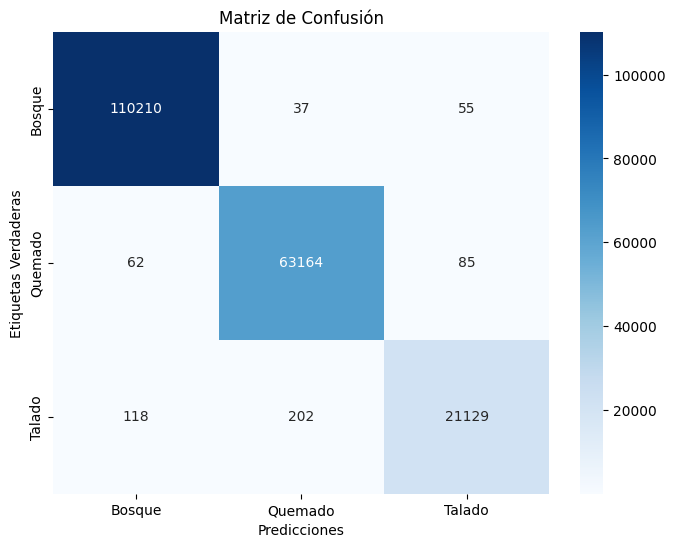

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Supongamos que tienes tus etiquetas reales en y_test y las predicciones en y_pred
confusion_mat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Utiliza seaborn para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

    

In [ ]:
from sklearn.model_selection import GridSearchCV

# Entrenar Regresión Logística
log_reg_model = LogisticRegression(max_iter=100000)
#log_reg_model.fit(X_train, y_train)

# Definir la cuadrícula de hiperparámetros para la búsqueda
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['None', 'l2'],
    'fit_intercept': [True, False]
}

# Realizar la búsqueda de hiperparámetros usando validación cruzada
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros para la Regresión Logística:")
print(grid_search.best_params_)


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints

Mejores hiperparámetros para la Regresión Logística:
{'C': 10.0, 'fit_intercept': True, 'penalty': 'l2'}


In [ ]:
# Evaluación
for model, name in zip([log_reg_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_pred = model.predict(X_test)
    print(f"Evaluation of {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Evaluation of Logistic Regression:
Accuracy: 0.9836314246182358


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    110554
           1       0.96      0.97      0.96     31054
           2       0.95      0.91      0.93     15950

    accuracy                           0.98    157558
   macro avg       0.97      0.96      0.96    157558
weighted avg       0.98      0.98      0.98    157558

Evaluation of Random Forest:
Accuracy: 0.9969661965752294
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110554
           1       0.99      1.00      0.99     31054
           2       0.99      0.98      0.99     15950

    accuracy                           1.00    157558
   macro avg       1.00      0.99      0.99    157558
weighted avg       1.00      1.00      1.00    157558

